In [1]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
!pip install -qU openimages urllib3 transformers
!mkdir -p train-images val-images test-images
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import transformers
import torchvision
import torch.nn as nn
from torchvision import transforms as T
from torch.nn.utils.rnn import pack_padded_sequence

from openimages.download import _download_images_by_id

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [3]:
torch.random.manual_seed(123)
np.random.seed(123)

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

EMBEDDING_DIM = 300
ATTENTION_DIM = 224
DECODER_DIM = 224
BATCH_SIZE = 128
MAX_SEQ_LEN=50
LR = 1e-3
EPOCHS = 50
IMAGE_SIZE = 224
BATCH_SIZE = 32
PATH = r'/content/drive/My Drive/data/caption_model.pth'
VOCAB_SIZE = tokenizer.vocab_size
clear_output()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')
np.random.shuffle(json_list)
data = []
N = 30000  # 10000
for ix, json_str in tqdm(enumerate(json_list), total=N):
    if ix == N: break
    try:
        result = json.loads(json_str)
        x = pd.DataFrame.from_dict(result, orient='index').T
        data.append(x)
    except:
        pass
data = pd.concat(data)
data.sample(5)

  0%|          | 0/30000 [00:00<?, ?it/s]

,dataset_id,image_id,annotator_id,caption
0,open_images,21f83bdad870a3b8,39,This picture shows a woman playing with a dog....
0,open_images,ed9c3bb7a95cf29b,68,This picture is clicked outside. In the center...
0,open_images,c28f80f0cfffcb84,85,"In this image I can see water, stairs, number ..."
0,open_images,7eaaa8c040e9a608,20,"In this image, in the middle, we can see a car..."
0,open_images,8df07f67063b6cf0,6,Man is playing the guitar and it's a mic at here.


In [5]:
train, test = train_test_split(data, test_size=0.01, shuffle=True, random_state=123)
train, valid = train_test_split(train, test_size=0.1, shuffle=True, random_state=123)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape, valid.shape, test.shape

((26730, 4), (2970, 4), (300, 4))

In [6]:
train_imageIds = train.image_id.to_list()
valid_imageIds = valid.image_id.to_list()
test_imageIds = test.image_id.to_list()

_download_images_by_id(train_imageIds, 'train', './train-images/')
_download_images_by_id(valid_imageIds, 'train', './val-images/')
_download_images_by_id(test_imageIds, 'train', './test-images/')
clear_output()

In [7]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.RandomCrop(IMAGE_SIZE),
                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.95, 1.05),
                                            hue=0.1),
                              T.RandomHorizontalFlip(p=0.1),
                              T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2)),
                              T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                              T.RandomRotation(degrees=(-5, 5)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])

In [8]:
class CapDataset(torch.utils.data.Dataset):
    def __init__(self, df, root, tokenizer, transforms=None):
        self.df = df
        self.root = root
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        id = row.image_id
        image_path = f'{self.root}/{id}.jpg'

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        caption = row.caption

        target = tokenizer(caption, 
                           return_token_type_ids=False, 
                           return_attention_mask=False, 
                           max_length=MAX_SEQ_LEN, 
                           padding="do_not_pad",
                           return_tensors="pt")
        target = target['input_ids'].squeeze()
        target = torch.LongTensor(target)
        return image, target, caption

    def collate_fn(self, batch):
        batch.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*batch)
        images = torch.stack([self.transforms(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

In [9]:
train_dataset = CapDataset(train, 'train-images', tokenizer, train_transforms)
valid_dataset = CapDataset(valid, 'val-images', tokenizer, valid_transforms)
test_dataset = CapDataset(test, 'test-images', tokenizer, valid_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE//4, shuffle=False, collate_fn=test_dataset.collate_fn)

In [ ]:
# test
tokenizer.decode(next(iter(train_dataloader))[1][0])

'[CLS] at the bottom of the image, we can see people, flags, stairs, stage, walkway and road. on the right side of the image, we can see people are walking on the road. few people are holding some objects. here there is a tree and statue. background there is a building, wall, windows, door and sky. on top of the building, there is a statue. [SEP]'

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        for param in self.resnet.parameters():
            param.requires_grad = False

        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = True

    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1)
        return out

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

class Decoder(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size=VOCAB_SIZE, encoder_dim=2048):
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0) # 32
        encoder_dim = encoder_out.size(-1) # 2048
        vocab_size = self.vocab_size # bert vocab size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        embeddings = self.embedding(encoded_captions)

        h, c = self.init_hidden_state(encoder_out)

        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.lstm(torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                             (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

    def predict(self, encoder_out, startseq_idx=101, endseq_idx=-1, max_len=MAX_SEQ_LEN, return_alpha=False):
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)
        batch_size = encoder_out.size(0)

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        h, c = self.init_hidden_state(encoder_out)

        sampled_ids = []  
        alphas = []

        prev_timestamp_words = torch.LongTensor([[startseq_idx]] * batch_size).to(device)
        for i in range(max_len):
            embeddings = self.embedding(prev_timestamp_words).squeeze(1)
            awe, alpha = self.attention(encoder_out, h)
            alpha = alpha.view(-1, enc_image_size, enc_image_size).unsqueeze(1)

            gate = self.sigmoid(self.f_beta(h))
            awe = gate * awe

            h, c = self.lstm(torch.cat([embeddings, awe], dim=1), (h, c))
            predicted_prob = self.fc(h)
            predicted = predicted_prob.argmax(1)

            sampled_ids.append(predicted)
            alphas.append(alpha)

            prev_timestamp_words = predicted.unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, 1)
        return (sampled_ids, torch.cat(alphas, 1)) if return_alpha else sampled_ids

class CapModel(nn.Module):
    def __init__(self, 
                 encoded_image_size=14, 
                 attention_dim=ATTENTION_DIM, 
                 embed_dim=EMBEDDING_DIM, 
                 decoder_dim=DECODER_DIM, 
                 vocab_size=VOCAB_SIZE, 
                 encoder_dim=2048):
        super(CapModel, self).__init__()
        self.encoder = Encoder(encoded_image_size=encoded_image_size)
        self.decoder = Decoder(attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim)

    def forward(self, images, encoded_captions, caption_lengths):
        encoder_out = self.encoder(images)
        decoder_out = self.decoder(encoder_out, encoded_captions, caption_lengths.unsqueeze(1))
        return decoder_out

    def predict(self, images, startseq_idx=101, endseq_idx=102, max_len=MAX_SEQ_LEN, return_alpha=False):
        encoder_out = self.encoder(images)
        return self.decoder.predict(encoder_out=encoder_out, startseq_idx=startseq_idx, max_len=max_len,
                                   return_alpha=return_alpha)

In [11]:
model = CapModel().to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [12]:
def bleu_score_fn(method_no: int = 4, ref_type='corpus'):
    smoothing_method = getattr(SmoothingFunction(), f'method{method_no}')
    
    def bleu_score_corpus(reference_corpus: list, candidate_corpus: list, n: int = 4):
        weights = [1 / n] * n
        return corpus_bleu(reference_corpus, candidate_corpus,
                           smoothing_function=smoothing_method, weights=weights)

    def bleu_score_sentence(reference_sentences: list, candidate_sentence: list, n: int = 4):
        weights = [1 / n] * n
        return sentence_bleu(reference_sentences, candidate_sentence,
                             smoothing_function=smoothing_method, weights=weights)
    if ref_type == 'corpus':
        return bleu_score_corpus
    elif ref_type == 'sentence':
        return bleu_score_sentence

def accuracy_fn(ignore_value: int = 0):
    def accuracy_ignoring_value(source: torch.Tensor, target: torch.Tensor):
        mask = target != ignore_value
        return (source[mask] == target[mask]).sum().item() / mask.sum().item()
    return accuracy_ignoring_value

def load_model(path, device=device):
    if device == 'cuda':
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    return epoch, model, optimizer

In [13]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None  # np.inf to save model after first epoch
        self.early_stop = False
        
    def __call__(self, val_loss, epoch=None, model=None, optimizer=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = { 
                          'epoch': epoch,
                          'model': model,
                          'optimizer': optimizer,
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6, factor=0.1)
early = EarlyStopping()

In [15]:
def train_one_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    images, captions, lengths = data
    scores, caps_sorted, decode_lengths, alphas, sort_ind = model(images, captions, lengths)
    targets = caps_sorted[:, 1:]

    scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
    targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

    loss = criterion(scores, targets)
    loss.backward()
    optimizer.step()

    accuracy = (torch.argmax(scores, dim=1) == targets).sum().float().item() / targets.size(0)

    return loss.item(), accuracy

@torch.no_grad()
def validate(model, data, criterion):
    model.eval()
    images, captions, lengths = data
    scores, caps_sorted, decode_lengths, alphas, sort_ind = model(images, captions, lengths)
    targets = caps_sorted[:, 1:]

    scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
    targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

    loss = criterion(scores, targets)
    accuracy = (torch.argmax(scores, dim=1) == targets).sum().float().item() / targets.size(0)

    return loss.item(), accuracy

@torch.no_grad()
def evaluate_model(dataloader, model, bleu_score_fn, tokenizer):
    running_bleu = [0.0] * 5
    model.eval()
    for batch_idx, batch in enumerate(tqdm(dataloader, leave=False)):
        images, captions, lengths = batch
        outputs = model.predict(images)

        captions = [[tokenizer.decode(cap).replace('[PAD]', '').split()[1:-1]] for cap in captions]
        outputs = [tokenizer.decode(out).replace('[PAD]', '').split('[SEP]')[0].split() for out in outputs] ###

        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(reference_corpus=captions, candidate_corpus=outputs, n=i)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(dataloader)
    return running_bleu

@torch.no_grad()
def plot_evaluation(model, dataloader, tokenizer):
    invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                          T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                      std = [ 1., 1., 1. ]),
                          T.ToPILImage(),
                         ])
    model.eval()
    element = np.random.randint(BATCH_SIZE)
    images, captions, _ = next(iter(dataloader))
    image = images[element]
    caption = captions[element]
    caption = tokenizer.decode(caption).replace('[PAD]', '')
    output = model.predict(image[None]).squeeze()
    output = tokenizer.decode(output).replace('[PAD]', '')
    output = output.split('[SEP]')[0] # that is, the prediction ends with [SEP]
    plt.figure(figsize=(6,6))
    plt.title(f'True: {caption}\nPredicted: {output}')
    image = invTrans(image.cpu().detach())
    plt.imshow(image, interpolation="bicubic")
    plt.show()
    plt.pause(0.001)

In [16]:
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')

try:
    ep, model, optimizer = load_model(PATH)
    ep += 1
except NameError:
    ep = 0

for epoch in range(ep, EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    epoch_train_losses, epoch_valid_losses = [], []
    epoch_train_acc, epoch_valid_acc = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        loss, accuracy = train_one_batch(model, batch, optimizer, criterion)
        epoch_train_losses.append(loss)
        epoch_train_acc.append(accuracy)

    epoch_train_loss = np.array(epoch_train_losses).mean()
    epoch_train_accuracy = np.array(epoch_train_acc).mean()
    train_losses.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    print(f'Train loss: {epoch_train_loss:.4f}, train accuracy: {epoch_train_accuracy:.4f}')

    for _, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        loss, accuracy = validate(model, batch, criterion)
        epoch_valid_losses.append(loss)
        epoch_valid_acc.append(accuracy)

    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    epoch_valid_accuracy = np.array(epoch_valid_acc).mean()
    valid_losses.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy)
    print(f'Valid loss: {epoch_valid_loss:.4f}, valid accuracy: {epoch_valid_accuracy:.4f}')

    print('-'*50)

    if (epoch + 1) % 2 == 0:
        train_bleu = evaluate_model(train_dataloader, model, corpus_bleu_score_fn, tokenizer)
        valid_bleu = evaluate_model(valid_dataloader, model, corpus_bleu_score_fn, tokenizer)
        print(''.join([f'train_bleu{i}: {train_bleu[i]:.4f} ' for i in (1, 4)]),
              ''.join([f'val_bleu{i}: {valid_bleu[i]:.4f} ' for i in (1, 4)]),)
        plot_evaluation(model, valid_dataloader, tokenizer)

    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, epoch, model, optimizer)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        ep, model, optimizer = load_model(PATH)
        break

Epoch 7/50


  0%|          | 0/835 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

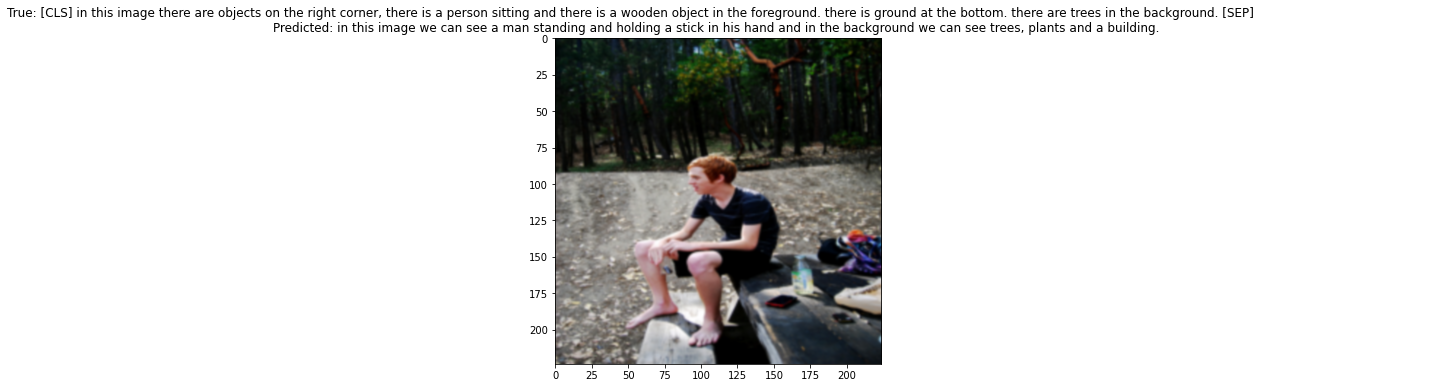

  0%|          | 0/38 [00:00<?, ?it/s]

[0.0,
 0.2849500914565771,
 0.1967465978918935,
 0.13827202333680763,
 0.09600048537242535]

In [17]:
plot_evaluation(model, valid_dataloader, tokenizer)
evaluate_model(test_dataloader, model, corpus_bleu_score_fn, tokenizer)

In [ ]:
# too big vocabulary
# too small dataset